

**Model Text Generation**

PIC: Amanda Eliora

In [ ]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Flatten, TimeDistributed, Dropout, LSTMCell, RNN, Bidirectional, Concatenate, Layer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.utils import tf_utils
from tensorflow.keras import backend as K
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import unicodedata
import re
import numpy as np
import os
import time
import shutil

import pandas as pd
import numpy as np
import re
import string, os 
tf.__version__

'2.7.0'

In [ ]:
# inisiliasi corpus
file = pd.read_csv('Twitter_Emotion_Dataset.csv')
corpus = [row for row in file['tweet']]

In [ ]:
# contoh isi corpus
corpus[30:40]

['Foto saya di instagram masih ada cuma lupa password instanya jadi ngga bisa di buka !! ini pasti salah pemerintah dan instagram kenapa sampai pakai password segala !! Tuh sampai lupa khan gw #begoloe ',
 'Drama kmarin sore : seharian puasa trus pas lg mandi kaget bcz kedatangan tamu tak diundang pas bgt woi pas lagi adzan maghrib trus jd galau dong seharian itu dianggap sah puasa apa enggak-_-',
 'Sungguh mencintaimu berat sekali. Berpisah denganmu apalagi. #HadiahPerasaan - [USERNAME] Selalu bikin baper tp sukses melupakan laper. [URL]',
 '4. pas uda dikirim kembali, si kurir telp ngeluh dan mager buat nganter ke alamat yg bener. malah minta ketemuan di titik yg dia tau itupun dia gamau susah (no puter balik, hrs searah sama arah kendaraan dia jalan)',
 'Pada akhirnya kita akan melewati semua ini, semua yang dulu kita bayangkan betapa sulitnya. Kita lalui juga. Di akhir kita hanya bisa belajar, belajar, dan belajar. Memetik semua hikmah yang bisa kita petik. Mempersiapkan untuk kede

In [ ]:
# jumlah data point dalam corpus
len(corpus)

4401

In [ ]:
small_corpus = corpus[0:1000]

In [ ]:
# Preprocessing data
# membuat semua huruf lowercase
# username dan url sudah di mask dalam dataset yang dipakai 

def preprocess(data):
  output = []
  for line in data:
    line = line.lower()
    output.append(line + '\n')
  return output

In [ ]:
processed_corpus = preprocess(small_corpus)

In [ ]:
# Tokenisasi dengan preprocessed corpus
tokenizer = Tokenizer()
tokenized_corpus = tokenizer.fit_on_texts(processed_corpus)
tokenized_corpus = tokenizer.texts_to_sequences(processed_corpus)

In [ ]:
# ukuran kosa kata
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

7866


In [ ]:
# Membagi data menjadi input dan output variables

data_X = []
data_Y = []
for line in tokenized_corpus:
  token_list = line
  for i in range(0, len(token_list)):
    seg_in = token_list[:i+1]
    seg_out = token_list[i+1:]
    data_X.append(seg_in)
    data_Y.append(seg_out)
n_patterns = len(data_X)
print("Total Patterns: ", n_patterns)

Total Patterns:  30384


In [ ]:
# padding data input
data_X = tf.keras.preprocessing.sequence.pad_sequences(data_X, padding="post")

In [ ]:
data_X

array([[ 239,    0,    0, ...,    0,    0,    0],
       [ 239, 1281,    0, ...,    0,    0,    0],
       [ 239, 1281, 1768, ...,    0,    0,    0],
       ...,
       [ 170,  191,  332, ...,    0,    0,    0],
       [ 170,  191,  332, ...,    0,    0,    0],
       [ 170,  191,  332, ...,    0,    0,    0]], dtype=int32)

In [ ]:
data_X.shape

(30384, 59)

In [ ]:
# padding data output
data_Y = tf.keras.preprocessing.sequence.pad_sequences(data_Y, padding="post")

In [ ]:
# tambah padding data output agar punya dimensi yang saya dengan data input
data_rows = data_Y.shape[0]
data_columns = data_X.shape[1] - data_Y.shape[1] 
zeros = np.zeros((data_rows, data_columns), dtype="int32")

data_Y = np.append(data_Y, zeros, axis=1)

In [ ]:
data_Y

array([[1281, 1768,  621, ...,    0,    0,    0],
       [1768,  621,  177, ...,    0,    0,    0],
       [ 621,  177,  360, ...,    0,    0,    0],
       ...,
       [ 139, 7865,    0, ...,    0,    0,    0],
       [7865,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]], dtype=int32)

In [ ]:
data_Y.shape

(30384, 59)

In [ ]:
# model dengan satu (1) LSTM layer
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=data_X.shape[1]))
model.add(LSTM(100, return_sequences=True))
model.add(Dense(100, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 59, 100)           786600    
                                                                 
 lstm (LSTM)                 (None, 59, 100)           80400     
                                                                 
 dense (Dense)               (None, 59, 100)           10100     
                                                                 
 dense_1 (Dense)             (None, 59, 7866)          794466    
                                                                 
Total params: 1,671,566
Trainable params: 1,671,566
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# compile model
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
# fit model, epochs = 5
history = model.fit(data_X, data_Y, batch_size=100, epochs=1)

304/304 [==============================] - 417s 1s/step - loss: 2.9442 - accuracy: 0.7291


In [ ]:
# save the model
model.save('model_LSTM1_epoch5.h5')

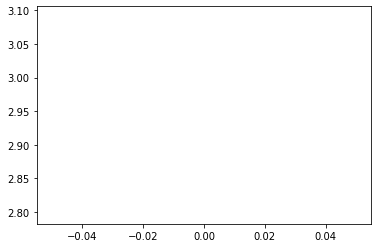

In [ ]:
# Graph hasil training
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label="Training loss")
#plt.plot(history.history['val_loss'], label="Validation loss")
plt.show()

In [ ]:
# model dengan tiga LSTM layer
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=data_X.shape[1]))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100, return_sequences=True))
model.add(Dense(100, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 59, 100)           786600    
                                                                 
 lstm_1 (LSTM)               (None, 59, 100)           80400     
                                                                 
 lstm_2 (LSTM)               (None, 59, 100)           80400     
                                                                 
 lstm_3 (LSTM)               (None, 59, 100)           80400     
                                                                 
 dense_2 (Dense)             (None, 59, 100)           10100     
                                                                 
 dense_3 (Dense)             (None, 59, 7866)          794466    
                                                                 
Total params: 1,832,366
Trainable params: 1,832,366
No

In [ ]:
# compile model
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
# fit model, epochs = 1
model.fit(data_X, data_Y, batch_size=100, epochs=1)

304/304 [==============================] - 486s 2s/step - loss: 2.8689 - accuracy: 0.7294


In [ ]:
# save the model
model.save('model_LSTM3_epoch5.h5')

In [ ]:
# Menggunakan model untuk mengenerate text
def generate_text_seq(model, tokenizer, seq_length, seed_text, n_words):
  text =[]

  for _ in range(n_words):
    encoded = tokenizer.texts_to_sequences([seed_text])[0]
    endoded = pad_sequences([encoded], maxlen = seq_length, truncating='pre')

    y_predic = model.predict_classes(encoded)

    predicted_word = ''
    for word, index in tokenizer.word_index.items():
      if index == y_predic:
        predicted_word = word
        break
    seed_text = seed_text + ' ' + predicted_word
    text.append(predicted_word)
  return ' '.join(text)

In [ ]:
# mencoba satu prediksi
# masih menemukan error dalam mengimplementasikan model-model yang sudah diciptakan untuk generate teks

seed_text = 'Foto saya di instagram masih ada cuma lupa password instanya'
generate_text_seq('model_LSTM3_epoch5.h5', tokenizer, 41, seed_text, 20)

AttributeError: ignored